## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

## Information about Author (Student)
- Name: Gabriel dos Santos Gonçalves
- Email: gabrielgoncalvesbr@gmail.com
- Github: GabrielSGoncalves

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

# for visualizing each feature distribution
import klib

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv('../../datasets/house-prices-advanced-regression-techniques/train.csv')

In [3]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [5]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [6]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [7]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [8]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Visual inspection of features
On this session I'm going to use klib to evaluate some characteristics of each feature from the dataset using the library `klib`. <br>
More information about it in the link below:
* https://github.com/akanz1/klib

```python

klib.missingval_plot(X_train)

klib.corr_plot(X_train, split='pos')

klib.dist_plot(X_train, showall=True)

klib.cat_plot(X_train.iloc[:,:15], top=4, bottom=4)
```

In [9]:
import plotly.graph_objects as go

In [10]:
X_train[X_train.MSSubClass.notnull()].MSSubClass

930      20
656      20
45      120
1348     20
55       20
       ... 
763      60
835      20
1216     90
559     120
684      60
Name: MSSubClass, Length: 1314, dtype: int64

In [11]:
#help(go.Histogram())

## Feature Engineering Pipeline

In [12]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [13]:
data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].dtypes

LotFrontage    float64
MasVnrArea     float64
GarageYrBlt    float64
dtype: object

In [14]:
data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']]

,LotFrontage,MasVnrArea,GarageYrBlt
0,65.0,196.0,2003.0
1,80.0,0.0,1976.0
2,68.0,162.0,2001.0
3,60.0,0.0,1998.0
4,84.0,350.0,2000.0
...,...,...,...
1455,62.0,0.0,1999.0
1456,85.0,119.0,1978.0
1457,66.0,0.0,1941.0
1458,68.0,0.0,1950.0


In [15]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddMissingIndicator(
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.05,
                                    n_categories=6,
                                    variables=categorical + discrete)),
    ('categorical_enc',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=categorical + discrete)),

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=5,
                                   return_object=True,
                                   variables=numerical)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=numerical)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [16]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories 

In [17]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 1035269885.2749027
train rmse: 32175.610099497768
train r2: 0.834193183650799

test mse: 2006905385.1371982
test rmse: 44798.49757678485
test r2: 0.7079639526659388


Text(0, 0.5, 'Predicted Price')

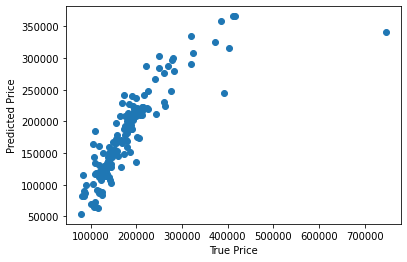

In [18]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

<AxesSubplot:>

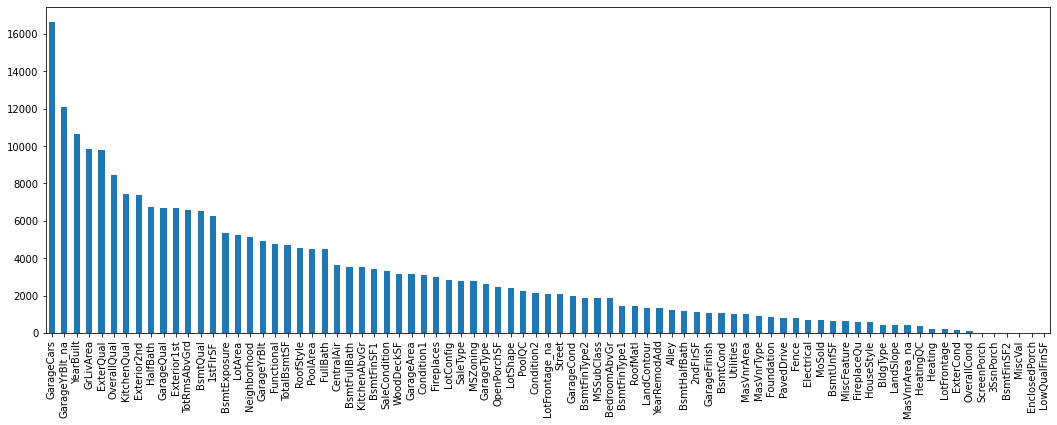

In [19]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))

In [20]:
X_train['GarageCars'] = X_train['GarageCars'].astype(int)

In [21]:
X_train['GarageCars'].value_counts()

2    740
1    333
3    164
0     74
4      3
Name: GarageCars, dtype: int64

## Testing `FeatureExplorer`

In [22]:
from feature_explorer import FeatureExplorer, _transform_numerical_feature, _get_histogram_trace
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [23]:
df_transformed = _transform_numerical_feature(X_train, 'GrLivArea')

In [24]:
df_transformed

,GrLivArea,GrLivArea_log,GrLivArea_reciprocal,GrLivArea_power,GrLivArea_sqrt,GrLivArea_boxcox,GrLivArea_yeojohnson
930,1466,7.290293,0.000682,2149156,38.288379,8.360881,8.338084
656,1053,6.959399,0.000950,1108809,32.449961,7.930884,7.910697
45,1752,7.468513,0.000571,3069504,41.856899,8.594655,8.570436
1348,1494,7.309212,0.000669,2232036,38.652296,8.385625,8.362678
55,1425,7.261927,0.000702,2030625,37.749172,8.323814,8.301242
...,...,...,...,...,...,...,...
763,2365,7.768533,0.000423,5593225,48.631266,8.991672,8.965017
835,1067,6.972606,0.000937,1138489,32.664966,7.947947,7.927657
1216,1902,7.550661,0.000526,3617604,43.611925,8.702926,8.678046
559,1557,7.350516,0.000642,2424249,39.458839,8.439705,8.416429


In [25]:
df_tranformed = pd.DataFrame(StandardScaler().fit_transform(df_transformed), columns= df_transformed.columns)

In [26]:
feat_explorer = FeatureExplorer(X_train, y_train, {}, 'regression')

### Create function to select transformed feature

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.notebook import tqdm


In [41]:
from typing import Sequence
import sklearn
def select_numerical_transformation(X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    feature: str,
    estimator: sklearn.base.BaseEstimator,
    scorer) -> pd.DataFrame:
    
    dict_scores = {}
    X_train = X_train.select_dtypes(include=["number"]).fillna(0)
    X_test = X_test.select_dtypes(include=["number"]).fillna(0)
    X_train_transformed = _transform_numerical_feature(X_train, feature).fillna(0)
    X_test_transformed = _transform_numerical_feature(X_test, feature).fillna(0)
    for col in tqdm(X_train_transformed.columns):        
        clf = estimator
        clf.fit(X_train_transformed[[col]], y_train)
        y_scored = clf.predict(X_test_transformed[[col]])
        dict_scores[col] = scorer(y_test, y_scored)
    
    selected_col = min(dict_scores.keys(), key=(lambda k: dict_scores[k]))

    return X_train_transformed[[selected_col]]

In [34]:
dict_scores = select_numerical_transformation(X_train, y_train, X_test, y_test, 'LotFrontage', LinearRegression(),mean_squared_error) 

In [51]:
X_test.GarageCars = X_test.GarageCars.astype(int)

In [52]:
X_train_numerical = X_train.select_dtypes(include=['number']).fillna(0)
X_test_numerical = X_test.select_dtypes(include=['number']).fillna(0)

In [53]:
X_train_numerical[X_test_numerical.columns]

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GrLivArea,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
930,73.0,8925,2,2,0.0,16,0,1450,1466,1466,...,1466,2.0,3,610,100,18,0,0,0,0
656,72.0,10007,49,2,54.0,806,0,247,1053,1053,...,1053,49.0,1,312,0,0,0,0,0,0
45,61.0,7658,5,5,412.0,456,0,1296,1752,1752,...,1752,5.0,2,576,196,82,0,0,0,0
1348,0.0,16196,9,9,0.0,1443,0,39,1482,1494,...,1494,9.0,2,514,402,25,0,0,0,0
55,100.0,10175,44,44,272.0,490,0,935,1425,1425,...,1425,44.0,2,576,0,0,0,407,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,82.0,9430,10,10,673.0,1163,0,89,1252,1268,...,2365,10.0,3,856,0,128,0,0,180,0
835,60.0,9600,60,15,0.0,442,0,625,1067,1067,...,1067,14.0,2,436,290,0,0,0,0,0
1216,68.0,8930,32,32,0.0,0,0,0,0,1318,...,1902,32.0,2,539,0,0,0,0,0,0
559,0.0,3196,3,2,18.0,0,0,1374,1374,1557,...,1557,3.0,2,420,143,20,0,0,0,0


In [54]:
X_test_numerical[X_train_numerical.columns]

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GrLivArea,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
529,0.0,32668,50,32,0.0,1219,0,816,2035,2515,...,2515,32.0,2,484,0,0,200,0,0,0
491,79.0,9490,65,56,0.0,403,165,238,806,958,...,1578,65.0,1,240,0,0,32,0,0,0
459,0.0,7015,59,59,161.0,185,0,524,709,979,...,1203,59.0,1,352,0,0,248,0,0,0
279,83.0,10005,31,31,299.0,392,0,768,1160,1156,...,2022,31.0,2,505,288,117,0,0,0,0
655,21.0,1680,39,39,381.0,0,0,525,525,525,...,1092,39.0,1,264,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,35.0,3675,1,1,80.0,547,0,0,547,1072,...,1072,1.0,2,525,0,28,0,0,0,0
113,0.0,21000,54,54,184.0,35,869,905,1809,2259,...,2259,54.0,2,450,166,120,192,0,0,0
1282,61.0,8800,32,1,0.0,532,144,364,1040,1040,...,1040,32.0,2,484,0,0,0,0,288,0
1163,60.0,12900,39,39,0.0,1198,0,0,1198,1258,...,1258,39.0,2,400,120,0,0,0,0,0


In [55]:
clf = LinearRegression()
clf.fit(X_train_numerical, y_train)
y_scored = clf.predict(X_test_numerical)
mean_squared_error(y_test, y_scored)

1524562179.8041904

In [57]:
df_transformed = pd.DataFrame()
for col in X_train_numerical.columns:
    col = select_numerical_transformation(X_train_numerical, y_train, X_test_numerical, y_test, col, LinearRegression(), mean_squared_error)
    df_transformed = pd.concat([df_transformed, col], axis=1)

/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/scipy/stats/morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/scipy/optimize/optimize.py:2522: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/scipy/optimize/optimize.py:2115: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/feature_engine/variable_transformers.py:245: RuntimeWarning: invalid value encountered in power
  X.loc[:, self.variables] = np.power(X.loc[:, self.variables], self.exp)


/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/scipy/stats/morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/scipy/optimize/optimize.py:2522: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/scipy/optimize/optimize.py:2115: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [58]:
df_transformed

,LotFrontage_power,LotArea_sqrt,YearBuilt_sqrt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2_boxcox,BsmtUnfSF_power,TotalBsmtSF,1stFlrSF_power,...,GrLivArea_power,GarageYrBlt_boxcox,GarageCars_boxcox,GarageArea_power,WoodDeckSF_sqrt,OpenPorchSF_log,EnclosedPorch_reciprocal,3SsnPorch_reciprocal,ScreenPorch_boxcox,MiscVal_boxcox
930,5329.0,94.472218,1.414214,2,0.0,16,0.0,2102500,1466,2149156,...,2149156,0.804153,1.660223,372100,10.000000,2.890372,0.0,0.000000,0.0000,0.0
656,5184.0,100.034994,7.000000,2,54.0,806,0.0,61009,1053,1108809,...,1108809,9.790772,0.000000,97344,0.000000,0.000000,0.0,0.000000,0.0000,0.0
45,3721.0,87.509999,2.236068,5,412.0,456,0.0,1679616,1752,3069504,...,3069504,2.296754,0.894240,331776,14.000000,4.406719,0.0,0.000000,0.0000,0.0
1348,0.0,127.263506,3.000000,9,0.0,1443,0.0,1521,1482,2232036,...,2232036,3.603688,0.894240,264196,20.049938,3.218876,0.0,0.000000,0.0000,0.0
55,10000.0,100.871205,6.633250,44,272.0,490,0.0,874225,1425,2030625,...,2030625,9.254298,0.894240,331776,0.000000,0.000000,0.0,0.002457,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,6724.0,97.108187,3.162278,10,673.0,1163,0.0,7921,1252,1607824,...,5593225,3.873862,1.660223,732736,0.000000,4.852030,0.0,0.000000,12.5787,0.0
835,3600.0,97.979590,7.745967,15,0.0,442,0.0,390625,1067,1138489,...,1138489,4.820953,0.894240,190096,17.029386,0.000000,0.0,0.000000,0.0000,0.0
1216,4624.0,94.498677,5.656854,32,0.0,0,0.0,0,0,1737124,...,3617604,7.801445,0.894240,290521,0.000000,0.000000,0.0,0.000000,0.0000,0.0
559,0.0,56.533176,1.732051,2,18.0,0,0.0,1887876,1374,2424249,...,2424249,1.394768,0.894240,176400,11.958261,2.995732,0.0,0.000000,0.0000,0.0


In [31]:
clf = LinearRegression()
clf.fit(df_transformed, y_train)
y_scored = clf.predict(X_test_numerical)
mean_squared_error(y_test, y_scored)

In [32]:
key_min

'LotFrontage_power'

In [79]:
dict_scores

{'GarageYrBlt': 5772232203.549101,
 'GarageYrBlt_log': 5929976576.928108,
 'GarageYrBlt_reciprocal': 6728276645.204274,
 'GarageYrBlt_power': 6148380236.658899,
 'GarageYrBlt_sqrt': 5795165319.3883295,
 'GarageYrBlt_boxcox': 5733184743.518626,
 'GarageYrBlt_yeojohnson': 5787503830.569543}

In [76]:
X_train_transformed

,GarageYrBlt,GarageYrBlt_log,GarageYrBlt_reciprocal,GarageYrBlt_power,GarageYrBlt_sqrt,GarageYrBlt_boxcox,GarageYrBlt_yeojohnson
930,2.0,0.693147,0.500000,4.0,1.414214,0.804153,1.320902
656,49.0,3.891820,0.020408,2401.0,7.000000,9.790772,7.908959
45,5.0,1.609438,0.200000,25.0,2.236068,2.296754,2.433146
1348,9.0,2.197225,0.111111,81.0,3.000000,3.603688,3.429445
55,44.0,3.784190,0.022727,1936.0,6.633250,9.254298,7.538547
...,...,...,...,...,...,...,...
763,10.0,2.302585,0.100000,100.0,3.162278,3.873862,3.634395
835,14.0,2.639057,0.071429,196.0,3.741657,4.820953,4.347142
1216,32.0,3.465736,0.031250,1024.0,5.656854,7.801445,6.519116
559,3.0,1.098612,0.333333,9.0,1.732051,1.394768,1.752265


In [77]:
X_train_transformed.GarageYrBlt_log.isnull().mean()

0.11339421613394216

In [78]:
feature = 'GarageYrBlt'
dict_scores = {}
estimator = LinearRegression()
scorer = mean_squared_error
X_train = X_train.select_dtypes(include=["number"]).fillna(0)
X_test = X_test.select_dtypes(include=["number"]).fillna(0)
X_train_transformed = _transform_numerical_feature(X_train, feature).fillna(0)
X_test_transformed = _transform_numerical_feature(X_test, feature).fillna(0)
for col in tqdm(X_train_transformed.columns):
    print(col)
    clf = estimator
    clf.fit(X_train_transformed[[col]], y_train)
    y_scored = clf.predict(X_test_transformed[[col]])
    dict_scores[col] = scorer(y_test, y_scored)

GarageYrBlt
GarageYrBlt_log
GarageYrBlt_reciprocal
GarageYrBlt_power
GarageYrBlt_sqrt
GarageYrBlt_boxcox
GarageYrBlt_yeojohnson



In [67]:
clf.fit(X_train_transformed[[col]], y_train)
y_scored = clf.predict(X_test[[col]])
mean_squared_error(y_test, y_scored)

6102589159.573513

In [47]:
X_train.select_dtypes(include=['number'])

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GrLivArea,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
930,73.0,8925,2,2,0.0,16,0,1450,1466,1466,...,1466,2.0,3,610,100,18,0,0,0,0
656,72.0,10007,49,2,54.0,806,0,247,1053,1053,...,1053,49.0,1,312,0,0,0,0,0,0
45,61.0,7658,5,5,412.0,456,0,1296,1752,1752,...,1752,5.0,2,576,196,82,0,0,0,0
1348,NaN,16196,9,9,0.0,1443,0,39,1482,1494,...,1494,9.0,2,514,402,25,0,0,0,0
55,100.0,10175,44,44,272.0,490,0,935,1425,1425,...,1425,44.0,2,576,0,0,0,407,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,82.0,9430,10,10,673.0,1163,0,89,1252,1268,...,2365,10.0,3,856,0,128,0,0,180,0
835,60.0,9600,60,15,0.0,442,0,625,1067,1067,...,1067,14.0,2,436,290,0,0,0,0,0
1216,68.0,8930,32,32,0.0,0,0,0,0,1318,...,1902,32.0,2,539,0,0,0,0,0,0
559,NaN,3196,3,2,18.0,0,0,1374,1374,1557,...,1557,3.0,2,420,143,20,0,0,0,0


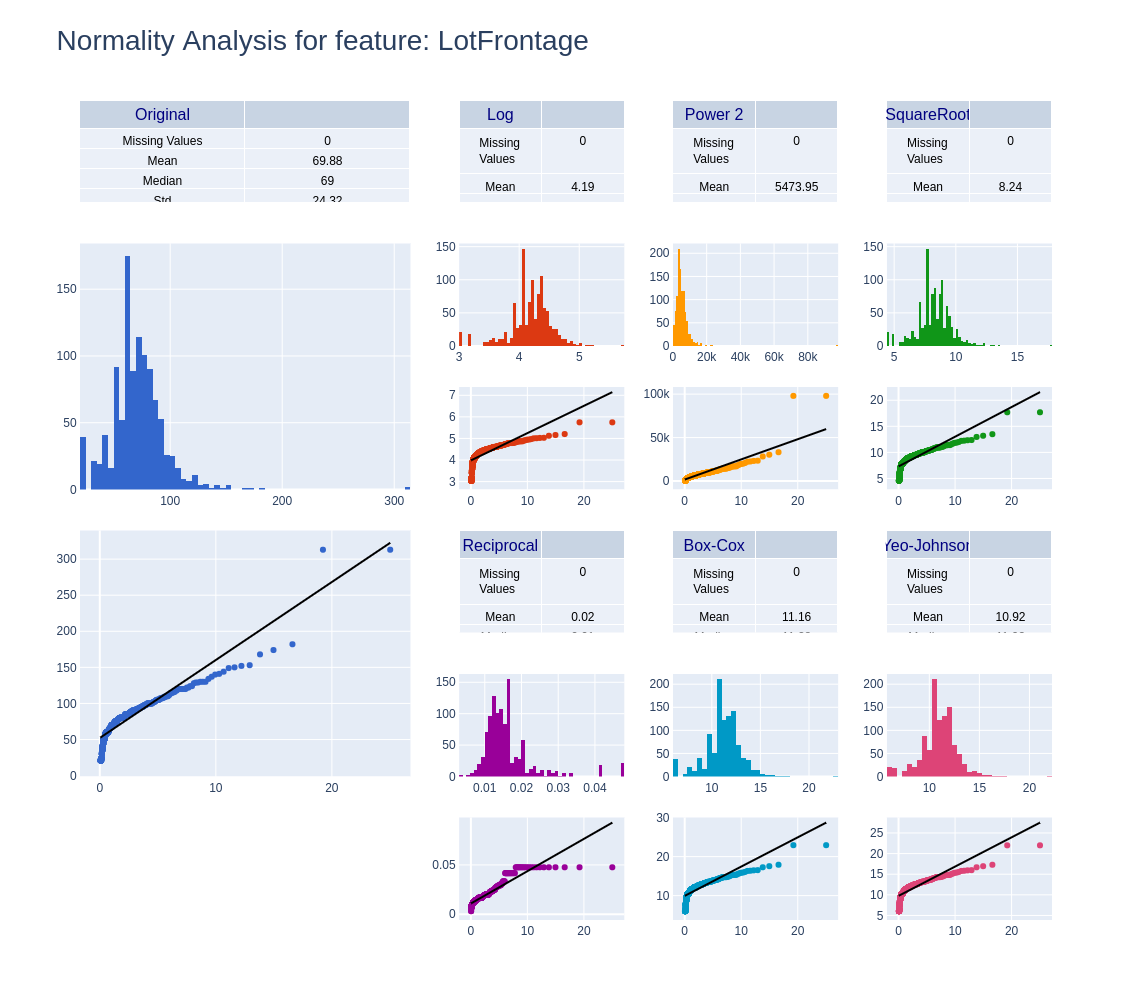

In [51]:
feat_explorer.plot_numerical_feature_info('LotFrontage',scaler=None, plot_size=(1200, 1000))

In [29]:
import plotly.express as px

print(px.colors.qualitative.Set1)

['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)', 'rgb(247,129,191)', 'rgb(153,153,153)']


### Transform categorical features

In [62]:
from feature_engine import categorical_encoders as ce


def _transform_categorical_feature(dataframe: pd.DataFrame, feature: str, target: str):
    """
    """
    # Validate for numeric
    df_filtered = dataframe[dataframe[feature].notnull()][[feature]]
    df_out = df_filtered.copy()

    # Perform transformations
    encoder_onehot = ce.OneHotCategoricalEncoder(variables=[feature], drop_last=True)
    encoder_frequency = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency',
                         variables=[feature])
    encoder_count = ce.CountFrequencyCategoricalEncoder(encoding_method='count',
                         variables=[feature])
    encoder_ordinal = ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                         variables=[feature])
    encoder_mean = ce.MeanCategoricalEncoder(variables=[feature])
    encoder_rarelabel = ce.RareLabelCategoricalEncoder(tol=0.05, n_categories=5,
                                         variables=[feature],
                                         replace_with='Rare')
    encoder_decisiontree = ce.DecisionTreeCategoricalEncoder(variables=[feature],random_state=161)
    
    # Perform transformations
    df_out = encoder_onehot.fit_transform(df_filtered)
    df_out[f'{feature}_frequency'] = encoder_frequency.fit_transform(df_filtered)
    df_out[f'{feature}_count'] = encoder_count.fit_transform(df_filtered)
    df_out[f'{feature}_ordinal'] = encoder_ordinal.fit_transform(df_filtered, target)
    df_out[f'{feature}_mean'] = encoder_mean.fit_transform(df_filtered, target)
    df_out[f'{feature}_rare'] = encoder_rarelabel.fit_transform(df_filtered, target)
    df_out[f'{feature}_decisiontree'] = encoder_decisiontree.fit_transform(df_filtered, target)
    


    return df_out

In [63]:
df_transformed = _transform_categorical_feature(X_train, 'Neighborhood', y_train)
df_transformed

,Neighborhood_Timber,Neighborhood_NAmes,Neighborhood_NridgHt,Neighborhood_SawyerW,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_OldTown,Neighborhood_NWAmes,Neighborhood_Crawfor,Neighborhood_Mitchel,...,Neighborhood_SWISU,Neighborhood_Veenker,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_frequency,Neighborhood_count,Neighborhood_ordinal,Neighborhood_mean,Neighborhood_rare,Neighborhood_decisiontree
930,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.027397,36,21,242555.638889,Rare,161221.080169
656,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.152968,201,10,146653.696517,NAmes,161221.080169
45,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0.054033,71,23,315191.901408,NridgHt,229409.457364
1348,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0.039574,52,12,186277.673077,Rare,229409.457364
55,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.152968,201,10,146653.696517,NAmes,161221.080169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.026636,35,24,330688.800000,Rare,330688.800000
835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.050989,67,6,136908.701493,Sawyer,136908.701493
1216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.050989,67,6,136908.701493,Sawyer,136908.701493
559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.012177,16,15,196269.062500,Rare,152393.709677


In [64]:
df_transformed.Neighborhood_decisiontree.value_counts()

198383.743333    300
229409.457364    258
161221.080169    237
126364.889474    190
183315.014085     71
136908.701493     67
125848.584906     53
330688.800000     35
97578.181818      33
152393.709677     31
304259.782609     23
99456.250000      16
Name: Neighborhood_decisiontree, dtype: int64

<AxesSubplot:ylabel='Frequency'>

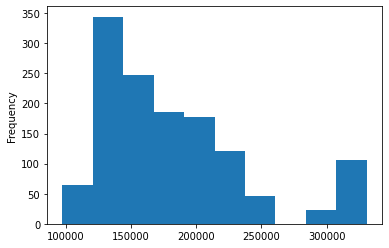

In [68]:
df_transformed.Neighborhood_mean.plot(kind='hist')

In [39]:
X_train.select_dtypes(include=['object'])

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MoSold,SaleType,SaleCondition
930,20,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,...,TA,TA,Y,0,NaN,NaN,NaN,7,WD,Normal
656,20,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,...,TA,TA,Y,0,NaN,MnPrv,NaN,8,WD,Normal
45,120,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,TA,TA,Y,0,NaN,NaN,NaN,2,WD,Normal
1348,20,RL,Pave,NaN,IR3,Low,AllPub,Inside,Gtl,SawyerW,...,TA,TA,Y,0,NaN,NaN,NaN,8,WD,Normal
55,20,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,...,TA,TA,Y,0,NaN,NaN,NaN,7,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,...,TA,TA,Y,0,NaN,NaN,NaN,7,WD,Normal
835,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,TA,TA,Y,0,NaN,NaN,NaN,2,WD,Normal
1216,90,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,TA,TA,Y,0,NaN,NaN,NaN,4,WD,Normal
559,120,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,...,TA,TA,Y,0,NaN,NaN,NaN,10,WD,Normal


In [58]:
X_train.Neighborhood.value_counts()

NAmes      201
CollgCr    135
OldTown    102
Edwards     88
Somerst     75
NridgHt     71
Gilbert     69
Sawyer      67
NWAmes      64
BrkSide     53
SawyerW     52
Mitchel     46
Crawfor     46
Timber      36
NoRidge     35
IDOTRR      33
ClearCr     26
SWISU       24
StoneBr     23
Blmngtn     16
MeadowV     16
BrDale      15
Veenker     11
NPkVill      8
Blueste      2
Name: Neighborhood, dtype: int64